In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.applications.vgg16 import VGG16,preprocess_input, decode_predictions
from keras.preprocessing import image as keras_image

In [ ]:
# Load VGG16 pre-trained on ImageNet without the top layer(classification layer)
base_model = VGG16(weights='imagenet', include_top=False,input_shape=(224, 224, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
# Freeze all the layers in the base model
for layer in base_model.layers:
  layer.trainable = False

In [ ]:
# Create custom layers for our new classification task
x = Flatten()(base_model.output)
x = Dense(1024, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

In [ ]:
# Combine the original model with the new layers
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
import os
import numpy as np
from skimage import io
from PIL import Image

In [ ]:
X=[]
Y=[]
base_path='/content/gdrive/My Drive/Covid_dataset'
source_path=base_path
for child in os.listdir(source_path):
  print(child)
  sub_path = os.path.join(source_path, child)
  bsub_path = os.path.join(base_path, child)
  if os.path.isdir(sub_path):
    for data_file in os.listdir(sub_path):
      Qry = Image.open(os.path.join(sub_path, data_file))
      Qry = Qry.convert("RGB")
      Qry = np.array(Qry.resize((224,224)))
      Qry = Qry.reshape([224,224,3])
      flist=np.array(Qry)
      X.append(flist)
      Y.append(child)

PNEUMONIA
NORMAL
Covid


In [ ]:
images_arr = np.asarray(X)
images_arr = images_arr.astype('float32')
images_arr = images_arr / np.max(images_arr)

In [ ]:
from sklearn.preprocessing import LabelBinarizer
labelBinarizer = LabelBinarizer()
y=labelBinarizer.fit_transform(Y)

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test =train_test_split(images_arr,y,test_size=0.2,random_state=42,stratify=y)

In [ ]:
# Train the model on your new dataset
model.fit(X_train, y_train, epochs=3,validation_data=(X_test, y_test))

Epoch 1/3
15/15 [==============================] - 398s 27s/step - loss: 0.1526 - accuracy: 0.9518 - val_loss: 0.2218 - val_accuracy: 0.9167
Epoch 2/3
15/15 [==============================] - 394s 26s/step - loss: 0.0849 - accuracy: 0.9686 - val_loss: 0.1840 - val_accuracy: 0.9333
Epoch 3/3
15/15 [==============================] - 395s 26s/step - loss: 0.0458 - accuracy: 0.9874 - val_loss: 0.1962 - val_accuracy: 0.9333


In [ ]:
testLoss, testAccuracy = model.evaluate(X_test,y_test)
print("Test Accuracy =", testAccuracy)

4/4 [==============================] - 78s 19s/step - loss: 0.1962 - accuracy: 0.9333
Test Accuracy = 0.9333333373069763


In [ ]:
model.save('dnnVGG16.keras')

In [ ]:
from tensorflow.keras.models import load_model
vgg_model = load_model("dnnVGG16.keras")

In [ ]:
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np

img_path = "/content/gdrive/MyDrive/lettuce/p3_aug_0.png"

In [ ]:
img = load_img(img_path, target_size=(224, 224,3)) # Load and resize the image

# If you need a NumPy array for further processing
img_array = img_to_array(img)

# Add a batch dimension (optional, depending on your model)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0

In [ ]:
# Get the last convolutional layer and the output layer of the model
last_conv_layer = vgg_model.get_layer('block5_conv3') #to get the last convolutional layer 'block5_conv3'-to get this name print model.summary and get the name, copy and paste it here
#Replace with the actual name of the last convolutional layer
classifier_layer_names = [layer.name for layer in vgg_model.layers if 'dense' in layer.name or 'fc' in layer.name]

In [ ]:
# Create a model that maps the input image to the activations of the last conv layer and the output layer
grad_model = tf.keras.models.Model( [vgg_model.inputs], [vgg_model.get_layer('block5_conv3').output,vgg_model.output]) # Model means functional model
 # i want to get ouput as probability

In [ ]:
# Get the gradient of the predicted class with respect to the output feature map of the last conv layer
with tf.GradientTape() as tape:
   #to generate gradient keras provide a parameter named tf.GradientTape()
  last_conv_layer_output, predictions = grad_model(img_array)
  predicted_class = tf.argmax(predictions[0])# to compute the high probability value of the predicted class
  grads = tape.gradient(predictions[:, predicted_class],  last_conv_layer_output) # used to differentiate highest probability value with the activation map and the differential info stored in grads

In [ ]:
# Compute the mean intensity of the gradient over each feature map
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

In [ ]:
# Multiply each channel in the feature map array by the "importance" of this channel
last_conv_layer_output = last_conv_layer_output[0] # only one image and it is stored in 'last_conv_layer_output[0]'
heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]# multiply it with pool_grads
heatmap = tf.reduce_mean(heatmap, axis=-1)

In [ ]:
# Apply ReLU to the resulting heatmap
heatmap = tf.maximum(heatmap, 0) #to remove -ve values ie.ReLU application

In [ ]:
# Normalize the heatmap
heatmap /= tf.math.reduce_max(heatmap) # to normalize this value for plotting in python

In [ ]:
# Convert the heatmap to numpy array
heatmap = heatmap.numpy() # change it into array

In [ ]:
import cv2
# Resize the heatmap to match the original image size
img = cv2.imread(img_path) # to resize it for superimposing for that heatmap is converte into our image size
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

In [ ]:
# Convert heatmap to RGB
heatmap = np.uint8(255 * heatmap) # preproceessing applied with max. pixel intensity value 255
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

In [ ]:
# Superimpose the heatmap on the original image
superimposed_img = cv2.addWeighted(img, 0.5, heatmap, 0.5, 0)# original image, its significance, heatma image, its significance , constant value ie. alpha*x+ Beta*heatmap+constant

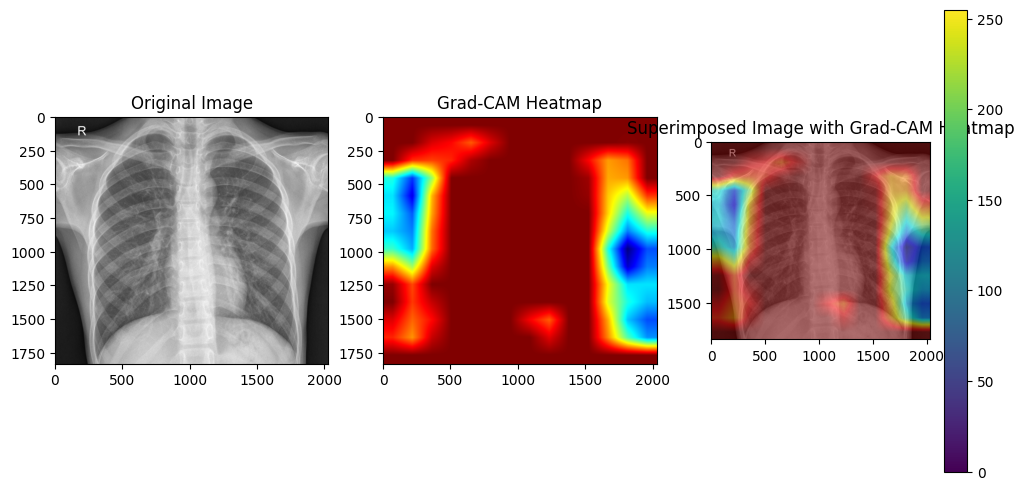

In [ ]:
import matplotlib.pyplot as plt
# Display the original image, heatmap, and the superimposed image
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(heatmap)
plt.title('Grad-CAM Heatmap')

plt.subplot(1, 3, 3)
plt.imshow(superimposed_img)
plt.title('Superimposed Image with Grad-CAM Heatmap')

#Plot. The visualization makes more sense if a symmetrical colorbar is used. to find low and high value
#plt.imshow(heatmap, cmap = 'RdBu', vmin = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()
plt.show()